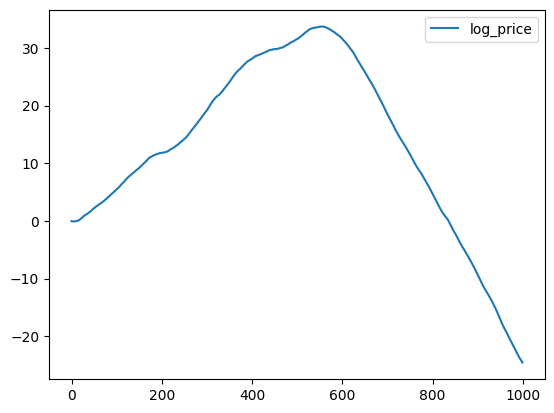

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# パラメータ設定
T = 1000  # データの長さ
a = 0.8  # AR(1)過程のパラメータ
b = 0.2
su = 0.01
sw = 0.005

# ノイズ生成
u = np.random.normal(0, su, T)
u[1:] = a * u[:-1] + np.random.normal(0, su, T - 1)
w = np.random.normal(0, su, T)
w[1:] = b * u[:-1] + np.random.normal(0, sw, T - 1)

# トレンドと対数価格の生成
trend = np.cumsum(w)
log_price = np.cumsum(trend + u)

# DataFrameに変換
df = pd.DataFrame({'log_price': log_price})
df.plot()
plt.show()

In [31]:
# カルマンフィルタの設定
kf = KalmanFilter(transition_matrices=[[1, 1], [0, 1]],
                  observation_matrices=[[1, 0]],
                  initial_state_mean=[0, 0],
                  initial_state_covariance=[[1, 0], [0, 1]],
                  observation_covariance=su,
                  transition_covariance=[[0, 0], [0, sw]])

In [46]:
# ポジション管理のための変数
position = 0  # 0: no position, 1: long, -1: short

lower95s = []
upper95s = []
lower60s = []
upper60s = []
for i in range(len(df)):
    # カルマンフィルタの更新（i時刻までのデータでフィルタリング）
    state_means, state_covs = kf.filter(df['log_price'].values[:i+1])
    
    # 信頼区間の計算
    lower95 = state_means[-1, 0] - 0.5 * np.sqrt(state_covs[-1, 0, 0])
    upper95 = state_means[-1, 0] + 0.5 * np.sqrt(state_covs[-1, 0, 0])
    lower60 = state_means[-1, 0] - 0.1 * np.sqrt(state_covs[-1, 0, 0])
    upper60 = state_means[-1, 0] + 0.1 * np.sqrt(state_covs[-1, 0, 0])

    lower95s.append(lower95)
    upper95s.append(upper95)
    lower60s.append(lower60)
    upper60s.append(upper60)

In [48]:
df["lower95"] = lower95s
df["upper95"] = upper95s
df["lower60"] = lower60s
df["upper60"] = upper60s

In [49]:
df

,log_price,log_price_f,lower95,lower80,upper95,upper80,lower60,upper60
0,-0.034582,-0.034240,-0.083992,-0.117823,0.015512,0.049343,-0.044190,-0.024289
1,-0.062883,-0.062602,-0.112356,-0.146189,-0.012848,0.020985,-0.072553,-0.052651
2,-0.078154,-0.080112,-0.126041,-0.157273,-0.034182,-0.002950,-0.089298,-0.070926
3,-0.090980,-0.093586,-0.136937,-0.166416,-0.050236,-0.020757,-0.102257,-0.084916
4,-0.091255,-0.096786,-0.139062,-0.167810,-0.054510,-0.025763,-0.105242,-0.088331
...,...,...,...,...,...,...,...,...
995,-24.033042,-24.027446,-24.069432,-24.097982,-23.985460,-23.956910,-24.035843,-24.019049
996,-24.164858,-24.162157,-24.204143,-24.232693,-24.120171,-24.091621,-24.170554,-24.153760
997,-24.284239,-24.287095,-24.329081,-24.357632,-24.245109,-24.216559,-24.295492,-24.278698
998,-24.408795,-24.410667,-24.452653,-24.481204,-24.368682,-24.340131,-24.419065,-24.402270


<Axes: >

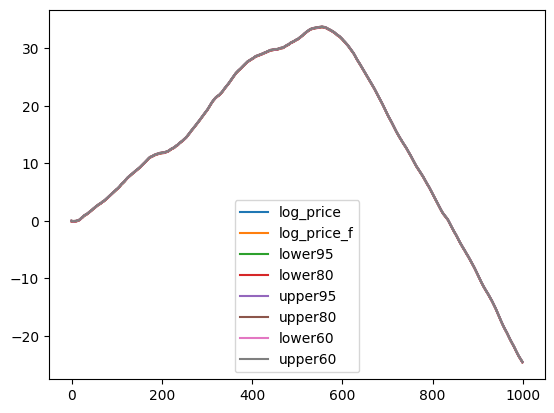

In [50]:
df.plot()